# The Takeover of Airbnb 
## By Yada Pruksachatkun and Andrea Jackson 

Airbnb, which according to their website is "a peer-to-peer online marketplace and homestay network that enables people to list or rent short-term lodging in residential properties, with the cost of such accommodation set by the property owner," has taken the world by storm. From New York to Australia, it is now possible for backpackers and business people alike to stay in the hospitality of someone else's home. 

We decided to measure how much Airbnb will grow. 

### Framing it as a Bayesian Problem 
We decided to look at how long it would take for a home to get listed in Airbnb, given that another home in the same neighborhood was listed. We defined a neighborhood as an equally sized square blcok, and decided to focus on New York Airbnb listing data. We defined each neighborhood to be 1x1 mile. 

This can be solved using Survival Analysis (Index 1). Survival Analysis is a family of mathematical methods to predict the time until the occurence of an event. 

We decided to use the Weibull distribution. The Probability Distribution Function, or PDF, equation of the weibull is as follows:

![title](img/pdf.jpg )


and the Cumulative Distribution Function (CDF) is as follows:

![title](img/cdf.jpg)


In [416]:
from __future__ import print_function, division
% matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import math
import numpy as np
import pandas as pd
import pickle
from itertools import product

### Data Source and Assumptions
To calculate the number of homes at a given time t that will have been listed on Airbnb, we need data that contains the location of the home, the zipcode of the home and the date that the home was listed on Airbnb.

The website [InsideAirbnb.com](http://insideairbnb.com/get-the-data.html) contains csv files of homes listed on Airbnb for cities in the United States. For our project, we decided to analyze the homes listed on Airbnb in New York City. We assume every listing in the InsideAirbnb data is unique and represents a different home/apartment/sublet per listing. The csv files also contained many columns that were not relevant for our project, such as customer reviews and links to images of the home. To get only the data we needed, we created a Dataframe from the csv file, removed the extra columns and created a pickle or serialized the dataframe.

For the total number of houses, we used data from the Internatioanl Revenue Service (IRS)'s Tax Income SOI spreadsheet, using the number of head of household returns to estimate the number of houses per zipcode. 

In [417]:
# This dataframe represents the data from InsideAirbnb.
df = pd.read_pickle("NYC_listing_pickle")

In [17]:
df.head(15)

,host_since,city,zipcode,latitude,longitude
id,,,,,
3943387,2014-08-23,Bronx,10464,40.839396,-73.781437
6627449,2014-04-04,City Island,10464,40.849775,-73.786609
11675715,2016-01-30,City Island,10464,40.850376,-73.784681
1886820,2013-11-04,Bronx,10464,40.841144,-73.783052
5557381,2015-03-05,Bronx,10464,40.850024,-73.789328
958444,2013-02-24,Bronx,10464,40.852350,-73.788728
8053533,2015-08-25,Bronx,10464,40.848202,-73.789293
9147025,2011-02-21,Bronx,10464,40.844870,-73.789541
7949480,2010-05-06,Bronx,10464,40.852054,-73.788680


Some of the data was formatted incorrectly or were in the zip+4 format, such as 11426-1175. Thus, we replaced those zipcodes with the corresponding zipcode using the function below. 

In [18]:
def replaceZipcodes(zipcodes,newZipcodes):
    '''Replaces the zipcode in the dataframe with 
    a new zipcode'''
    for i,z in zip(zipcodes,newZipcodes):
        index = df[df['zipcode'] == i].index.tolist()
        df.set_value(index,'zipcode',z).head(5)

In [19]:
zipcodes = ['11426-1175','10002-2289','10003\n10003','10003-8623','11205-4471',
            '8456422473 call for more details','11103-3233']
newZipcodes = ['11426','10002','10003','10003','11205','10021','11103']
replaceZipcodes(zipcodes,newZipcodes)

#### We defined each neighborhood to be 1x1 mile. Using a calculator (see index below), we found the distance of the longitude to be 32.64 miles (52.53 km) by longitude and 33.64 miles (54.13 km) by latitude. 

### Assumptions

#### We assume every listing in airbnb listing.csv is unique and represents a different home/apartment/sublet (living residence). Furthermore, we will find the number of houses in a neighborhood using motovo.com. All homes listed on motovo.com when we input the zipcode, will represent the number of homes in that zipcode and the neighborhood. 

In [6]:
import geopy

In [7]:
df.zipcode.head(10)

id
3943387     10464
6627449     10464
11675715    10464
1886820     10464
5557381     10464
958444      10464
8053533     10464
9147025     10464
7949480     10464
755528      10467
Name: zipcode, dtype: object

In [8]:
coordinateList = zip(df.latitude, df.longitude, df.zipcode)

Because we were dividing the neighborhoods into grids, we had to measure the number of miles there were per change in coordinate system. Using a calculator (see index below), we found the distance to be 32.64 miles (52.53 km) by longitude and 33.64 miles (54.13 km) by latitude. 
We decided to divide our grid up from (0,0) to (32, 33), where each square will be a neighborhood. To map the listed Airbnb listings per square, we created the find_distance function to find the distance of a house from the minimum longitude and latitude. Thus, we used the below formula to calculate which neighborhood a listing should be in, such that i and j are the corresponding indices in the n_grid hashmap. 


                                          
                                          
                                            
                                            
                                           

$ i =  x_{lat} - min_{lat} $
                                            

$ j =  x_{long} - min_{long}$

In [9]:
max_lat = df.max(axis=0)['latitude']
max_long =  df.max(axis=0)['longitude']
min_lat = df.min(axis=0)['latitude']
min_long = df.min(axis=0)['longitude']
max_long_row = df.loc[df['longitude']== max_long]
min_long_row = df.loc[df['longitude']== min_long]
max_lat_row = df.loc[df['latitude']== max_lat]
min_lat_row = df.loc[df['latitude']== min_lat]
corresponding_long_of_min_lat = -74.240843
corresponding_lat_of_min_long = 40.499794

We used geopy to calculate the distance between two coordinates. 

In [10]:
from geopy import distance

def find_distance(in_lat, in_long):
    '''Paramters: Lat and long of house listing.
       Output: 0 < lat < 33.64 and 0 < long < 32.64
       We calculate the long difference and lat difference by isolating 
       the variables and fixing the other to be the corresponding fixed 
       varaible of the minimum free variable. 
    '''
    diff_long = distance.vincenty((corresponding_lat_of_min_long, in_long), (corresponding_lat_of_min_long, min_long)).miles
    diff_lat = distance.vincenty((in_lat,  corresponding_long_of_min_lat), (min_lat, corresponding_long_of_min_lat)).miles
    return (diff_lat, diff_long)

In [11]:
find_distance(40.783605,-73.967515)

(19.58333832402766, 14.396840047098028)

In [12]:
import math
n_grid = {}
n_grid_zipcodes = {}

def is_nan(num):
    return num != num

from decimal import *
getcontext().prec = 2

def round_num(x):
    return int(x)
   # return float("{0:.2f}".format(x))
index = 0
for coor in coordinateList:
    latitude,longitude, zipcode = coor
    res_distance = find_distance(latitude,longitude)
    out_distance = (round_num(res_distance[0]), round_num(res_distance[1]))
    # places lat,long values in zipcode grid
    if is_nan(zipcode) is False:
        if type(zipcode) is float:
            zipcode = int(zipcode) 
        zipcode = str(zipcode)
        if n_grid_zipcodes.get(zipcode) is None:
            n_grid_zipcodes[zipcode] = set() 
        n_grid_zipcodes[zipcode].add(out_distance)
        
    # counts the number of neighborhoods per zipcode
    if  n_grid.get(out_distance) is None:
        n_grid[out_distance] = []
    else:
        n_grid[out_distance].append(index)
    index = index + 1

In [13]:
# import json
# with open('n_grid.txt', 'w') as outfile:
#     json.dump(str(n_grid), outfile)

Below, we load the data from the CSV file containing the zipcode to the number of houses in the zipcode.

In [28]:
import csv
zipcodes_to_num_houses = {}
def represents_int(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False
    
with open('households.csv', 'rb') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
        if represents_int(row[1]):  
            zipcodes_to_num_houses[row[0]] = int(row[1])

In [19]:
from itertools import islice
n = len(n_grid_zipcodes)
def take(n,iterable):
    ''''Return first n iterms of the iterable as a list'''
    return list(islice(iterable,n))

In [15]:
firstHalfOrig = [10270,10279,10280,10281,10282,12337,10301,10303,10304,10305,10308,10312,10314,11354,11355,11356,11357,
11358,11360,11361,11362,11364,11365,11366,11367,11368,11369,11370,11372,11373,11374,11375,11377,11379,11385,10080,7305,
11411,11412,11413,11415,11416,11417,11418,11419,11421,11423,11426,11427,11432,11434,11435,10451,10452,10453,10454,
10455,10456,10457,10458,10459,10460,10462,10463,10464,10465,10466,10467,10468,10469,10471,10472,10473,10475,11001,
11004,10001,10002,10003,10004,10005,10006]

In [16]:
firstHalfOrigString = [str(i) for i in firstHalfOrig]
b = set(firstHalfOrigString)

In [18]:
n = len(n_grid_zipcodes)

In [19]:
allZipcodes = take((n),n_grid_zipcodes)
c = set(allZipcodes)

In [20]:
secondHalfOrig = c-b

We then calculated the birth date of each neighborhood, which is based on the event of the first listing from each neighborhood. The function below finds the date of the firs tlisting for each neighborhood in n_grid. Based on the birth date of the neighborhood, we calculated the age of death for the remaining listings in the neighborhood, storing that data into a hashmap called neighborhood_data. From herein, age will refer to the number of days passed since the date of listing of the first house. 

In [21]:
relative_times = {}
import time
from datetime import datetime
        
def find_min():
    '''find the pioneer - the first home in a
    neighborhood to be listed on Airbnb'''
    min_hashmap = {}
    for key, value in n_grid.iteritems():
        if len(value) > 0:
            min_value = time.strftime("%Y-%m-%d")
            for i in range(len(value)):
                host_since = df.iloc[i].host_since
                host_datetime = time.strptime(host_since, "%Y-%m-%d")
                if min_value < host_datetime:
                    min_value = host_since
            min_hashmap[key] = [min_value]
    return min_hashmap

min_hashmap = find_min()    

In [22]:
def get_relative_times():
    '''Calculate the age of house listings in neighborhood based on
    pioneer'''
    relative_times = {}
    for key, value in n_grid.iteritems():
        if len(value) > 0:
            min_time = min_hashmap[key]
            min_time_l = datetime.strptime(min_time[0],"%Y-%m-%d")
            for i in range(len(value)):
                index = value[i]
                curr_since = df.iloc[index].host_since
                if type(curr_since) is not float:
                    curr_datetime = datetime.strptime(str(curr_since),"%Y-%m-%d")
                    diff = abs((curr_datetime - min_time_l).days) 
                    #diff_months = math.floor(diff/30)
                    if relative_times.get(key) is None:
                        relative_times[key] = [str(diff)]
                    else:
                        relative_times[key].append(str(diff))
    return relative_times

relative_times = get_relative_times()

In [26]:
# import json
# with open('min_hashmap.txt', 'w') as outfile:
#     json.dump(str(min_hashmap), outfile)

In [27]:
# with open('relative_hashmap_months.txt', 'w') as outfile:
#     json.dump(str(relative_times), outfile)

In [5]:
def prepare_data(grid,rel_hash):
    '''iterate through each neighborhood in grid and format 
    each listing as (isListed,age).
    isListed: a boolean value
    age: number of days that have passed since pioneer was listed on Airbnb
    
    Return a dictionary where the key is the neighborhood coordinates
    and the value is a list of tuples. Each tuple represents a home in that neighborhood'''
    n_dict = {}
    for key, val in grid.iteritems():
        homes = []
        if len(val) > 0:
#             print (key)
#             print (val)
            listedHomes = rel_hash[key]
            for age in listedHomes:
                f_age = float(age)
                homes.append((True,int(f_age)))
            n_dict[key] = homes
        else:
            pass
    return n_dict
        

In [26]:
neighborhoodData = prepareData(n_grid,relative_times)

Below are the functions of the Weibull distribution, as provided by Professor Allen Downey. 

In [28]:
# The following Weibull functions were written by Professor Allen Downey, Olin College of Engineering 
def EvalWeibullPdf(x, lam, k):
    """Computes the Weibull PDF.

    x: value
    lam: parameter lambda in events per unit time
    k: parameter

    returns: float probability density
    """
    arg = (x / lam)
    return k / lam * arg**(k-1) * np.exp(-arg**k)

def EvalWeibullCdf(x, lam, k):
    """Evaluates CDF of the Weibull distribution."""
    arg = (x / lam)
    return 1 - np.exp(-arg**k)

def MakeWeibullPmf(lam, k, high, n=200):
    """Makes a PMF discrete approx to a Weibull distribution.

    lam: parameter lambda in events per unit time
    k: parameter
    high: upper bound
    n: number of values in the Pmf

    returns: normalized Pmf
    """
    xs = np.linspace(0, high, n)
    ps = EvalWeibullPdf(xs, lam, k)
    return Pmf(dict(zip(xs, ps)))

We then created a class to represent the PMF of an Airbnb listing under the Weibull distribution. If the data is false, meaning the house is unlisted, then we return the Weibull PDF, which calculates the survival rate (or the probablity the house would remain unlisted at the house's current age). If the data is true, meaning the house is listed, then we return the Weibull CDF, which inversely calculate the probability of the house dying at any date up to the house's current age. 

In [29]:
class Airbnb(Suite, Joint):
    
    def Likelihood(self, data, hypo):
        lam,k = hypo
        
        if lam == 0:
            return 0
        
        isListed,age = data
        
        if isListed == True:
            like = EvalWeibullPdf(age, lam, k)
            
        elif isListed == False:
            like = 1 - EvalWeibullCdf(age, lam, k)
            
        else:
            raise ValueError('Invalid data')
            
        return like

In [30]:
# our estimates of k and lambda
lams = np.linspace(0, 5, 101)
ks = np.linspace(0, 5, 101)

def findNeighborhoodPmfs(neighborhood_data):
    '''for each neighborhood coordinate in neighborhood data
    the function will find the pmf for each neighborhood.
    fcn returns a dictionary where the key is the neighborhood coordinate
    and value is the pmf'''
    pmf_dict = {}
    
    for n_coord,ages in neighborhood_data.iteritems():  
        print (str(n_coord))
        suite = Airbnb(product(lams,ks))
        data = neighborhood_data[n_coord]

        try:
            suite.UpdateSet(data)
            pmf_dict[n_coord] = (suite)
        
        #if total probability is zero
        except ValueError: 
            pmf_dict[n_coord] = (None)

    return pmf_dict

In [130]:
def MakeWeibullCdf(lam, k, high, n=200):
    """Makes a Cdf approx to a Weibull distribution.
    """
    xs = np.linspace(0, high, n)
    ps = EvalWeibullCdf(xs, lam, k)
    return Cdf(dict(zip(xs, ps)))

In [221]:
# Find the neighborhoods whose total probability was 0 
# and who were assigned None in findNeighborhoodsPmfs
noneList = []
for coord,pmf in neighborhoodPMF.iteritems():
    suite = neighborhoodPMF[coord]
    if suite is None:
        noneList.append(coord)      

The number of neighborhoods in our coordinate system whose calculated total probability was 0.

In [228]:
len(noneList)

218

The total number of neighborhoods in our coordinate system.

In [229]:
len(n_grid)

289

In [247]:
def findValidNeighborhoods(d,noneList):
    '''returns a new dictionary of valid neighborhood coordinates
    as the keys and pmfs as the values'''
    newDict = {}
    for coords, pmf in d.iteritems():
        if coords not in noneList:
            newDict[coords] = pmf
    return newDict###  Further Steps 
It is possible to analytically calculate the time (t) in which the failure rate (or the rate at which the probaiblity that another house will be listed on Airbnb) is below 0.01 as a further step. 
To do this, we analytically derived, based on the Hazard function, functions that will calculate the time x such that

In [248]:
validNeigh = findValidNeighborhoods(neighborhoodPMF,noneList)

### References
https://www.google.com/webhp?sourceid=chrome-instant&ion=1&espv=2&ie=UTF-8#q=2014+New+York+SOI+Tax+csv

In [252]:
coordinates = validNeigh.keys()
coordinate_df = pd.DataFrame({'coordinates': coordinates})

In [253]:
coordinate_df

,coordinates
0,"(28, 18)"
1,"(4, 7)"
2,"(27, 17)"
3,"(7, 16)"
4,"(9, 4)"
5,"(6, 12)"
6,"(9, 6)"
7,"(7, 11)"
8,"(8, 5)"
9,"(19, 20)"


### Coordinates (28, 18)

In [362]:
suite_0 = neighborhoodPMF[(28,18)]
lam_0, k_0 = suite_0.Random()
weibullcdf_0 = MakeWeibullCdf(lam_0,k_0,10)

{'xscale': 'linear', 'yscale': 'linear'}

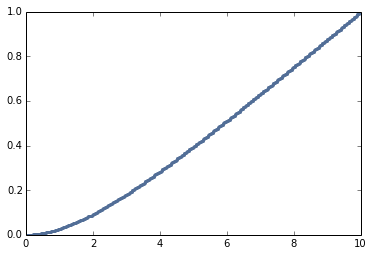

In [364]:
thinkplot.Cdf(weibullcdf_0)

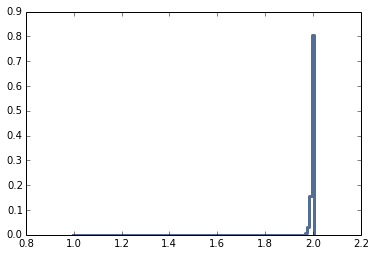

In [365]:
marginalLam_0 = suite_0.Marginal(0)
thinkplot.Pmf(marginalLam_0)

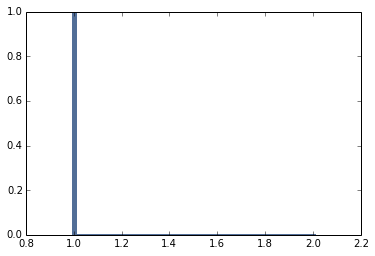

In [366]:
marginalK_0 = suite_0.Marginal(1)
thinkplot.Pmf(marginalK_0)

### Coordinates (19, 24) 

In [388]:
suite_23 = neighborhoodPMF[(19,24)]
lam_23, k_23 = suite_23.Random()
weibullcdf_23 = MakeWeibullCdf(lam_23,k_23,10)

{'xscale': 'linear', 'yscale': 'linear'}

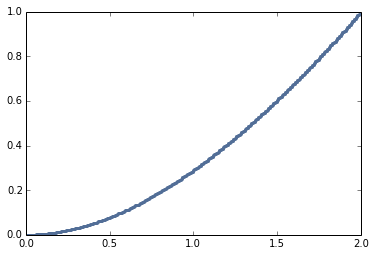

In [313]:
thinkplot.Cdf(weibullcdf_23)

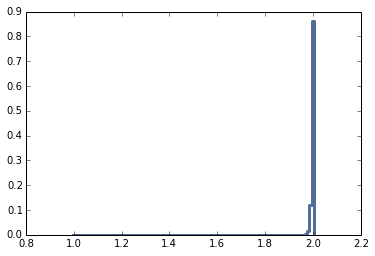

In [390]:
marginalLam_23 = suite_23.Marginal(0)
thinkplot.Pmf(marginalLam_23)

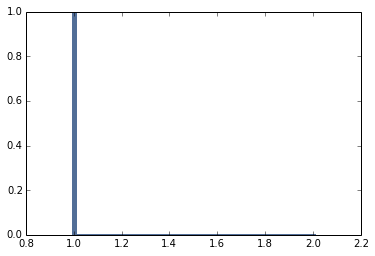

In [391]:
marginalK_23 = suite_23.Marginal(1)
thinkplot.Pmf(marginalK_23)

### Coordinates (2, 4)

In [409]:
suite_36 = neighborhoodPMF[(2,4)]
lam_36, k_36 = suite_36.Random()
weibullcdf_36 = MakeWeibullCdf(lam_36,k_36,10)

In [410]:
weibullcdf_36[1]

0.025669542694866831

{'xscale': 'linear', 'yscale': 'linear'}

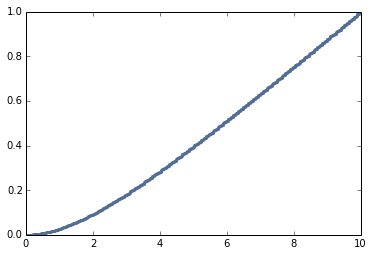

In [411]:
thinkplot.Cdf(weibullcdf_36)

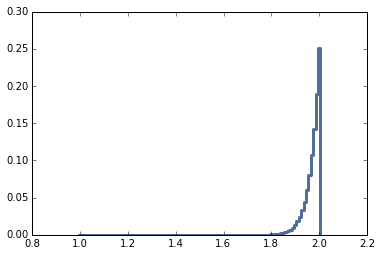

In [412]:
marginalLam_36 = suite_36.Marginal(0)
thinkplot.Pmf(marginalLam_36)

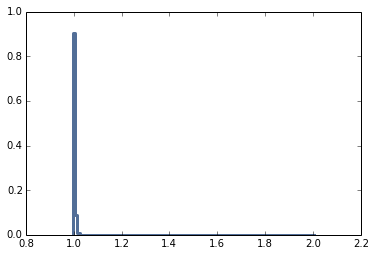

In [414]:
marginalK_36 = suite_36.Marginal(1)
thinkplot.Pmf(marginalK_36)

In [415]:
# prob = EvalWeibullCdf(x, lam, k)

Now, given ks and lambdas, at what time frame will the neighborhood be Airbnb-saturated (meaning there are no more additional houses that will get onto Airbnb)? We shall find the time using the Hazard function. 

In [421]:
import math
from scipy.optimize import minimize_scalar
x_pos = np.linspace(0.0, 1000.0, num=1000)

#We want to find the x that makes the hazard function gets as close to 0.01 as possible. 

def reverse_hazard_function(k, lam):
    def r_h_f(x):
        const = 0.01
        numer = (k * x**(k-1))
        denom = (lam**k)
        exp = math.exp(-((x/lam)**k))
        return (((numer/denom) + const)* exp) - const
    return r_h_f

def not_neg(x):
    return not (x < 0)

def find_min_x(k,lam):
    function = reverse_hazard_function(k, lam)
    res = map(function,x_pos)
    res_d = {}
    for r in range(len(res)):
        res_d[res[r]] = r
    res = filter(not_neg, res)
    min_r =  min(res)
    return res_d[min_r]
